In [33]:
from ML.EFPs.data_loaders import load_data_qg_tagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Loading the Dataset

In [6]:
root_data_folder = "../../../Data"
X_train, y_train = load_data_qg_tagging(
    quark_data_path=f"{root_data_folder}/Trainning/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Trainning/g_jets_efps_d5_primed.npy"
)
X_val, y_val = load_data_qg_tagging(
    quark_data_path=f"{root_data_folder}/Validation/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"{root_data_folder}/Validation/g_jets_efps_d5_primed.npy"
)

#### Creating the Decision Tree

In [28]:
# First we perform a grid search to look for the best hiperparamers for the model
model = DecisionTreeClassifier(criterion="entropy")

# first search - Best result: max_depth=10 min_samples_split=100
# second search - Best result: max_depth=10 min_samples_split=200
# third search - Best result: max_depth=9 min_samples_split=200
# fourth search - Best result: max_depth=9 min_samples_split=250
params_for_search = {
    # 1. [10, 20, 30, 40],
    # 2. [5, 10, 15],
    # 3. [8, 9, 10, 11, 12]
    # 4. [9]
    "max_depth": [9],
    # 1. [10, 20, 30, 40, 50, 100],
    # 2. [100, 125, 150, 200],
    # 3. [200]
    # 4. [200, 250, 300]
    "min_samples_split": [200, 250, 300]
}

grid_search = GridSearchCV(model, params_for_search, return_train_score=True, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END max_depth=9, min_samples_split=200;, score=(train=0.792, test=0.789) total time=   6.8s
[CV 2/5] END max_depth=9, min_samples_split=200;, score=(train=0.793, test=0.782) total time=   6.9s
[CV 3/5] END max_depth=9, min_samples_split=200;, score=(train=0.793, test=0.786) total time=   6.9s
[CV 4/5] END max_depth=9, min_samples_split=200;, score=(train=0.793, test=0.787) total time=   6.9s
[CV 5/5] END max_depth=9, min_samples_split=200;, score=(train=0.793, test=0.787) total time=   6.8s
[CV 1/5] END max_depth=9, min_samples_split=250;, score=(train=0.792, test=0.789) total time=   6.7s
[CV 2/5] END max_depth=9, min_samples_split=250;, score=(train=0.793, test=0.782) total time=   6.7s
[CV 3/5] END max_depth=9, min_samples_split=250;, score=(train=0.793, test=0.786) total time=   6.7s
[CV 4/5] END max_depth=9, min_samples_split=250;, score=(train=0.793, test=0.787) total time=   6.7s
[CV 5/5] END max_depth=9, min_s

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': [9],
                         'min_samples_split': [200, 250, 300]},
             return_train_score=True, verbose=3)

In [29]:
pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,params,mean_test_score
1,"{'max_depth': 9, 'min_samples_split': 250}",0.786283
2,"{'max_depth': 9, 'min_samples_split': 300}",0.786259
0,"{'max_depth': 9, 'min_samples_split': 200}",0.786175


In [30]:
# trainning a tree with max_depth equal to 9 and min_samples_split equal to 250
tree = DecisionTreeClassifier(criterion="entropy", max_depth=9, min_samples_split=250)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=250)

In [43]:
tree.feature_importances_

array([8.51976244e-01, 1.11035029e-01, 1.74483862e-03, 7.64639202e-03,
       7.51722481e-03, 3.93850694e-03, 9.35248845e-04, 1.14719154e-03,
       4.63556354e-04, 5.64070176e-04, 6.71958858e-04, 0.00000000e+00,
       3.88262202e-03, 3.28897594e-04, 7.52728634e-04, 1.14596668e-04,
       2.16810168e-03, 1.95222837e-04, 0.00000000e+00, 1.75135877e-04,
       2.12857702e-04, 2.05327736e-04, 0.00000000e+00, 0.00000000e+00,
       3.71798781e-04, 3.49836922e-04, 0.00000000e+00, 4.16924005e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.91566537e-04, 9.50535098e-05, 5.77546296e-04, 1.87841896e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08500714e-04,
       0.00000000e+00, 4.28873833e-05, 0.00000000e+00, 1.09763764e-04,
       7.83845168e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.69414331e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [32]:
y_val_predict = tree.predict(X_val)

print("Validation set:")
print(f"Recall for Quark tagging: {recall_score(y_val, y_val_predict):.2f}")
print(f"Precision for Quark tagging: {precision_score(y_val, y_val_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_val, y_val_predict, labels=[0, 1]))

Validation set:
Recall for Quark tagging: 0.77
Precision for Quark tagging: 0.79
Confusion Matrix
[[18106  4494]
 [ 5012 16750]]


AUC: 0.866


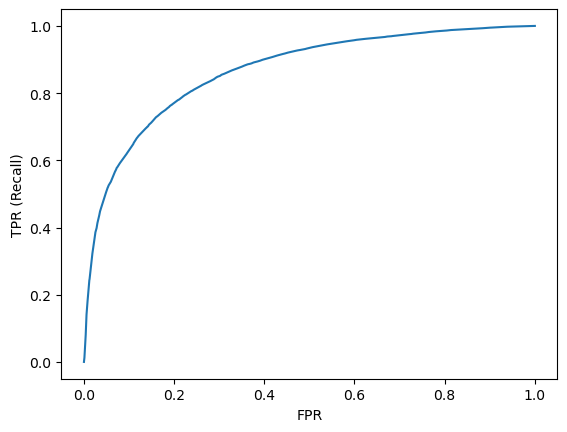

In [42]:
# roc curve on the validation set
y_score = tree.predict_proba(X_val)

# roc curve for top tagging 
fpr, tpr, _ = roc_curve(y_val, y_score[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
print(f"AUC: {auc(fpr, tpr):.3f}")